In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
DATA_PATH = "/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/"

<h1 style = "font-size: 42px; text-align: center;"> Analysis Overview </h1>
<h2 style = "text-align: center;"> Exploring the cell cycle time series data, fluorescent channels and the drug response </h2>

## 1 - FUCCI Manifold Analysis

In the extraction script, we filtered out less than $72dt$ to get rid of tracking errors.
For each well we have dataframes containing the cell image and fluroescent signals. These raw signals $( \tilde{f}_r , \tilde{f}_g ) $ are the observable functions of the phase $Z$. 

In [3]:
# Merged channels pickle is a dataframe that concatenates the raw signals from all the wells. Takes a 1m to load
merged_channels = pd.read_pickle(DATA_PATH + "merged_channels.pkl");merged_channels.sample()

CELL_ID FRAME                               CHANNEL_SUM AREA  \
72286  0503.668   589  [821800, 60186, 79027, 6727676, 1123246]  361   

               POSITION  PARENT condition  
72286  [1345.2, 1503.8]     663   Control

In [26]:
normal_cells = merged_channels.query('condition == "Control"')
signal = np.array(normal_cells['CHANNEL_SUM'].tolist())
size = np.array(normal_cells['AREA'].tolist())
log_signal = np.log2(signal)
log_signal_scaled = np.log2(signal/size[:, None])

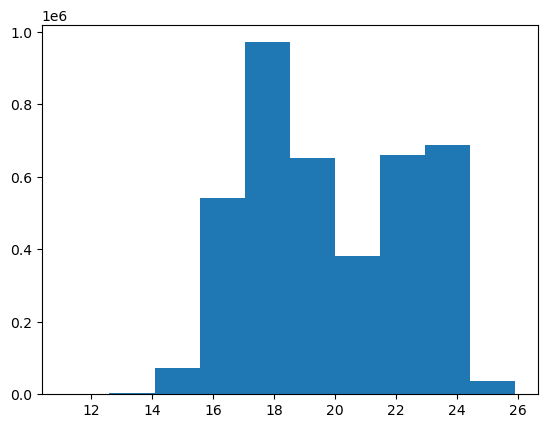

(array([1.160000e+02, 2.901000e+03, 6.640500e+04, 7.924440e+05,
        2.709660e+05, 4.591580e+05, 1.078203e+06, 1.093443e+06,
        2.121240e+05, 2.930700e+04]),
 array([ 9.7548875 , 11.35177037, 12.94865325, 14.54553612, 16.14241899,
        17.73930186, 19.33618473, 20.9330676 , 22.52995048, 24.12683335,
        25.72371622]),
 <BarContainer object of 10 artists>)

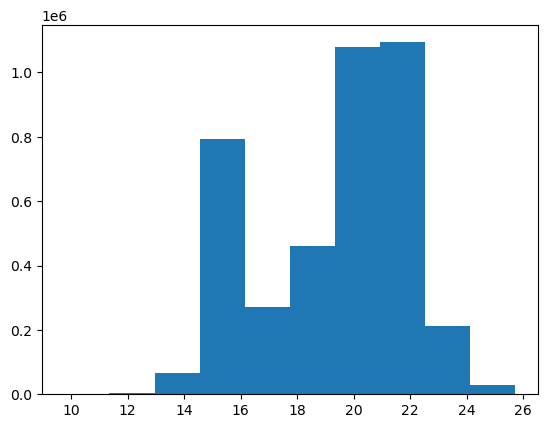

In [27]:
plt.hist(log_signal[:, 1])
plt.show()
plt.hist(log_signal[:, 2])

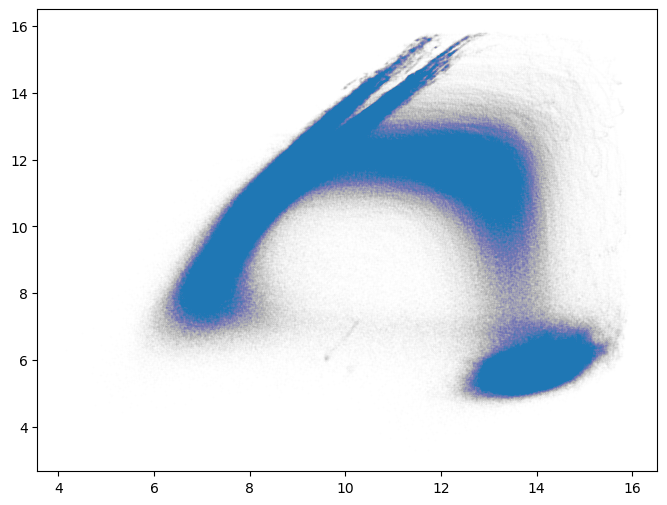

In [31]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.scatter(log_signal_scaled[:, 1], log_signal_scaled[:, 2], s=1, alpha=0.005)

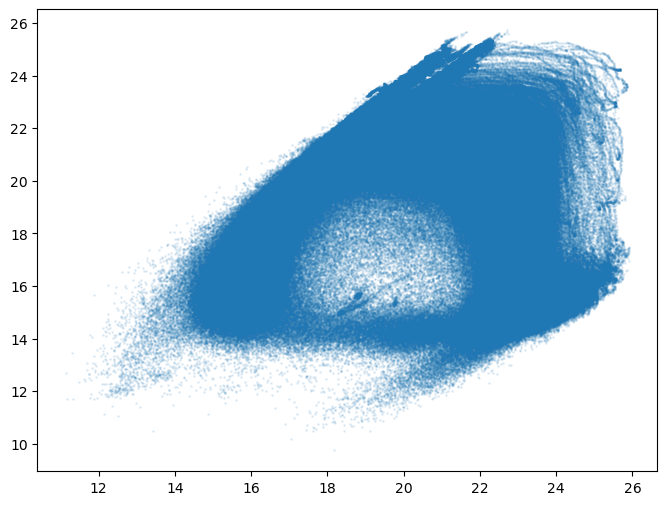

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.scatter(log_signal[:, 1], log_signal[:, 2], s=1, alpha=0.1)

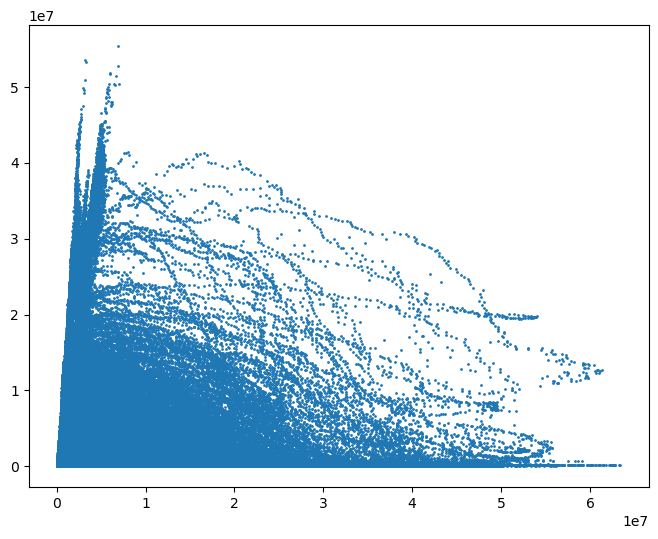

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.scatter(signal[:, 1], signal[:, 2], s=1)

In [ ]:
# Let's take a look at the complete track dataset
path = "/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/track_datasets/complete/"; tracks = []; tracks_well = []
for subset in ['train', 'test']: 
    for track_file in os.listdir(path + subset + '/labels/'):
         tracks_well.append(track_file.split('.')[0]); tracks.append(np.load(path + subset + '/labels/' + track_file, allow_pickle=True))
complete_filtered_tracks = pd.DataFrame({'condition':[conditions_dict[well] for well in tracks_well], 'track': tracks}); complete_filtered_tracks['DELTA_T'] = complete_filtered_tracks['track'].apply(lambda t: len(t[0]))


In [ ]:
# Lets take a look at the FUCCI Manifold and color it with respect to the normalized time: tau = t\track_length
complete_filtered_tracks['fucci1'] = complete_filtered_tracks['track'].apply(lambda t: t[0]); complete_filtered_tracks['fucci2'] = complete_filtered_tracks['track'].apply(lambda t: t[1])
complete_filtered_tracks['tau'] = complete_filtered_tracks['fucci1'].apply(lambda f1: np.linspace(0, 1, len(f1)))
datapoints = complete_filtered_tracks[['condition', 'fucci1', 'fucci2', 'tau']].explode(['fucci1', 'fucci2', 'tau'])
datapoints.sample()

condition    fucci1    fucci2       tau
5119   control  0.063997  0.261206  0.084629

### Fucci Manifold

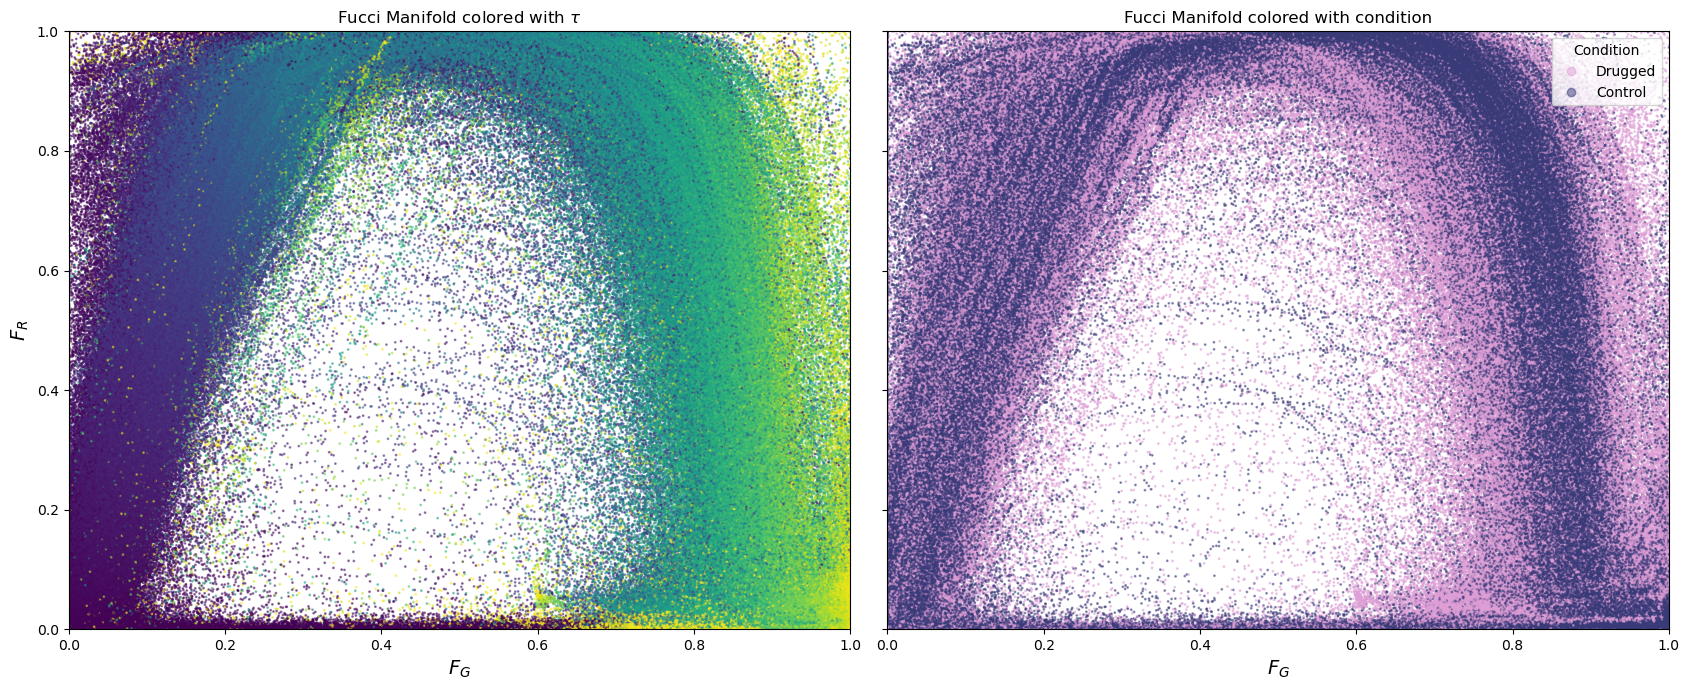

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)
ax[0].scatter(datapoints['fucci1'], datapoints['fucci2'], s=1, alpha=0.5, c=datapoints['tau'], cmap='viridis')
scatter = ax[1].scatter(datapoints['fucci1'], datapoints['fucci2'], s=1, alpha=0.5, c=datapoints['condition'] == 'control', cmap=mpl.colormaps['tab20b'].reversed())
ax[0].set_xlim(0,1);ax[0].set_ylim(0,1); ax[0].set_xlabel('$F_G$', fontsize = 14); ax[0].set_ylabel('$F_R$', fontsize = 14);  ax[1].set_xlabel('$F_G$', fontsize = 14)
ax[0].set_title('Fucci Manifold colored with $\\tau$', fontsize=12); ax[1].set_title('Fucci Manifold colored with condition', fontsize=12)
ax[1].legend(scatter.legend_elements()[0], ["Drugged", "Control"],loc = "upper right", title="Condition"); plt.tight_layout();plt.show()


growth rate with parents = 0 and ratio of cells created from that res track, look at range of fucci values, fucci manifold animation, explain log information, view cell tracks images in 1 plot, take a look at cell speed and acceleration, make animation in well, deterministic phase function, histograms of cell area, tree structure. 

### Salati Plots
Fucci signals plotted versus normalized time and their fourier series approximation, which we define as the vanilla model $V$, the following cell takes 2mins to run as it fits 2 million points twice but the vanilla model weights are saved at ```vanilla_weights.npy```

In [ ]:
# Let's start by getting a fourier series approximation of the FUCCI system
def linear_regression(x, y, n_harmonics=100):
    # Setting up matrix of cosines and sines
    A = np.ones((len(x), 1 + 2 * n_harmonics))  # include column for intercept
    for k in range(1, n_harmonics + 1): A[:, 2 * k - 1] = np.cos(2 * np.pi * k * x); A[:, 2 * k] = np.sin(2 * np.pi * k * x) 
    # Solve the fourrier approximation as a least squares problem
    coeffs, _, _, _ = np.linalg.lstsq(A, y, rcond=None)
    return coeffs

#vanilla_weights = np.stack([linear_regression(datapoints['tau'].values.astype(float), datapoints['fucci1'].values.astype(float)), 
#                            linear_regression(datapoints['tau'].values.astype(float), datapoints['fucci2'].values.astype(float))])
vanilla_weights = np.load('vanilla_weights_control.npy')
print(vanilla_weights.shape)

(2, 201)


In [ ]:
# Vanilla Model wrapped in a PyTorch NN Module so it can benchmark predictions later
import torch
import torch.nn as nn

class Vanilla_Model(nn.Module):
    # Initialize model with weights learned through least squares of the design matrix
    def __init__(self, weights_dir):
        super(Vanilla_Model, self).__init__()
        self.weights = np.load(weights_dir); self.n_harmonics = (self.weights.shape[1] - 1) // 2

    def forward(self, x):
        tau_space = np.linspace(0, 1, x.shape[1]); k_values = np.arange(1, self.n_harmonics + 1)
        # Fourier Design Matrix for specific number of time points
        A = np.ones((len(tau_space), 1 + 2 * self.n_harmonics))
        cosine_terms = np.cos(2 * np.pi * k_values[:, None] * tau_space).T; sine_terms = np.sin(2 * np.pi * k_values[:, None] * tau_space).T
        A[:, 1::2] = cosine_terms; A[:, 2::2] = sine_terms
        
        # Get Vanilla Prediction
        vanilla_prediction = np.stack([A.dot(c) for c in self.weights]).T
        # Wrap output in tensor unsqueezed for a Batch Dimension
        return torch.tensor(vanilla_prediction,dtype=torch.float32).unsqueeze(0) 
V = Vanilla_Model('vanilla_weights_control.npy')

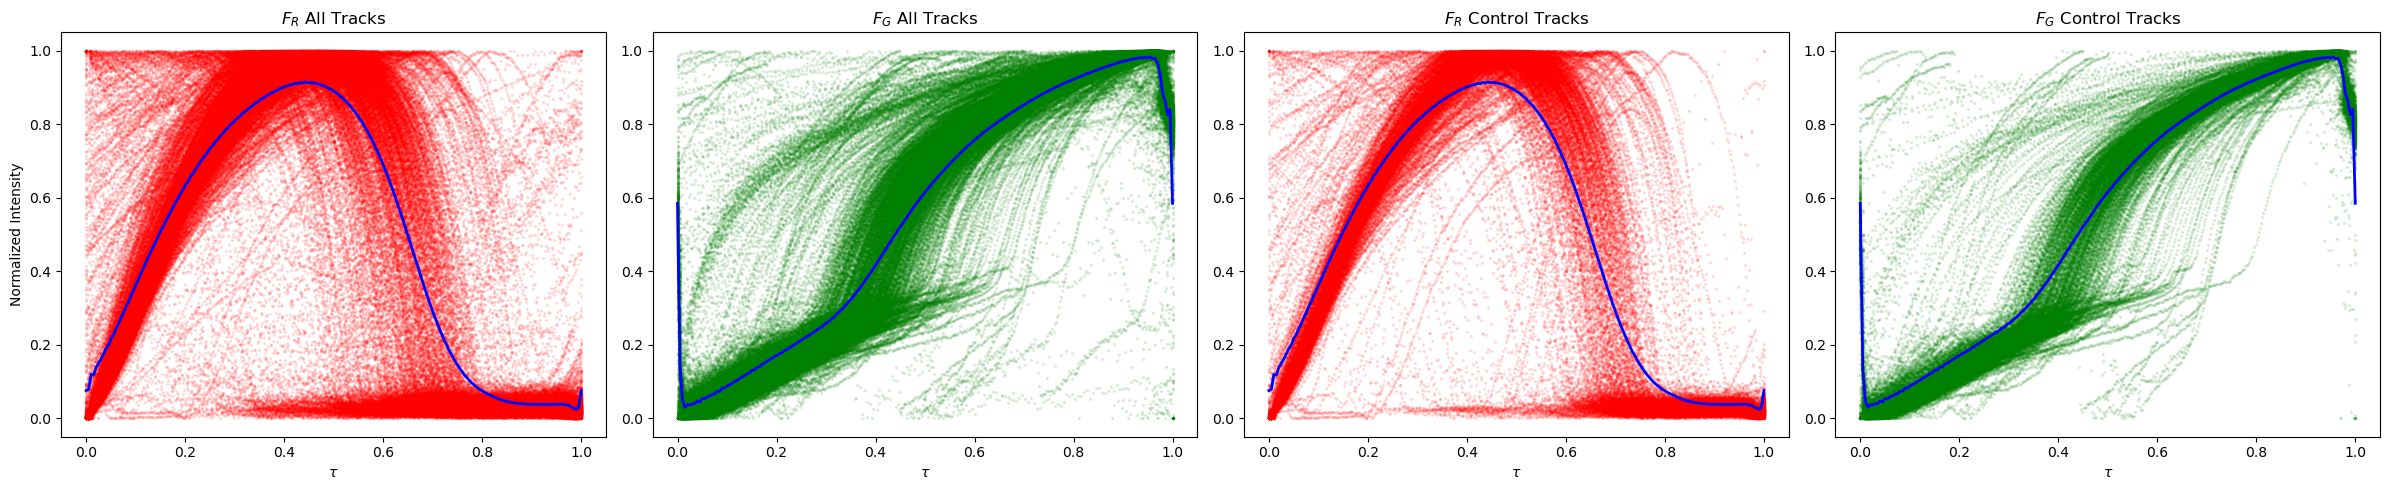

In [ ]:
# Lets have a look at our tracks per signal / Andrea's nice plots, for rendering purpose we plotted the first 1k tracks, script runs in 15s
fig, ax = plt.subplots(1, 4, figsize = (24, 5))
for row, track in complete_filtered_tracks.iterrows():
    if (row < 1e3): 
        ax[0].scatter(track['tau'], track['fucci2'], color = "red", s=2, alpha=0.1);ax[1].scatter(track['tau'], track['fucci1'], color = "green", s=2, alpha=0.1)
        if (track['condition'] == 'control'): ax[2].scatter(track['tau'], track['fucci2'], color = "red", s=2, alpha=0.1); ax[3].scatter(track['tau'], track['fucci1'], color = "green", s=2, alpha=0.1)
for i in range(4): ax[i].plot(np.linspace(0, 1, 200), V(torch.randn(1,200))[0, :, (i+1)%2], "blue", lw=2); ax[i].set_xlabel('$\\tau$')
for i, condition in enumerate(["All", "Control"]): ax[2*i].set_title(f'$F_R$ {condition} Tracks'); ax[2*i + 1].set_title(f'$F_G$ {condition} Tracks');
ax[0].set_ylabel('Normalized Intensity'); plt.tight_layout();plt.show()

### PCA Analysis on the variability of the cell cycle

We can actually run a PCA on the FUCCI manifold per condition to grasp the total variability of the cell cycle and in doing so estimating the Vanilla Model's performance 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1, random_state=5)
def get_explained_variance(points, pca): pca.fit_transform(points[['fucci1', 'fucci2']]); return pca.explained_variance_ratio_
explained_variance_per_condition = pd.DataFrame(datapoints.groupby('condition').apply(lambda points: get_explained_variance(points, pca)))
datapoints['control'] = datapoints['condition'] == 'control'
explained_variance_per_control = pd.DataFrame(datapoints.groupby('control').apply(lambda points: get_explained_variance(points, pca)))
pca.fit_transform(datapoints[['fucci1', 'fucci2']]); explained_variance_all = pca.explained_variance_ratio_
explained_variance_per_condition, explained_variance_per_control, explained_variance_all

(                              0
 condition                      
 Aph        [0.7551353207140858]
 No         [0.6929645886382549]
 Ro         [0.7334998220172059]
 cdk        [0.7278419599088719]
 control    [0.6985822713970086]
 mtor       [0.7952113002593252],
                             0
 control                      
 False    [0.7393934386828445]
 True     [0.6985822713970086],
 array([0.71826515]))